# Segment Building Footprints in Fused Dataset (OpenAI, CrowdAI, Inria, Massachusetts)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.7.1
fastai        : 1.0.53.post2
fastprogress  : 0.1.19
torch         : 1.1.0
nvidia driver : 415.27
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 6075MB | GeForce GTX 1060 6GB

=== Environment === 
platform      : Linux-4.15.0-51-generic-x86_64-with-debian-buster-sid
distro        : #55-Ubuntu SMP Wed May 15 14:27:21 UTC 2019
conda env     : fastai1
python        : /home/splash/anaconda3/envs/fastai1/bin/python
sys.path      : /home/splash/aerial-mapping
/home/splash/anaconda3/envs/fastai1/lib/python37.zip
/home/splash/anaconda3/envs/fastai1/lib/python3.7
/home/splash/anaconda3/envs/fastai1/lib/python3.7/lib-dynload

/home/splash/anaconda3/envs/fastai1/lib/python3.7/site-packages
/home/splash/anaconda3/envs/fastai1/lib/python3.7/site-packages/IPython/extensions
/home/splash/.ipython

Mon Jun 17 14:50:34 2019       
+--------------------------

## Load Data

In [4]:
path = Path('/media/splash/00F2D259F2D25310/Data/final')
path.ls()

[PosixPath('/media/splash/00F2D259F2D25310/Data/final/arid.tif'),
 PosixPath('/media/splash/00F2D259F2D25310/Data/final/images'),
 PosixPath('/media/splash/00F2D259F2D25310/Data/final/isb.tif'),
 PosixPath('/media/splash/00F2D259F2D25310/Data/final/isb.tif.aux.xml'),
 PosixPath('/media/splash/00F2D259F2D25310/Data/final/labels'),
 PosixPath('/media/splash/00F2D259F2D25310/Data/final/outputs')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([PosixPath('/media/splash/00F2D259F2D25310/Data/final/images/grid_029_corrected_19_319454_270707_224_224_129_165_nw.png'),
  PosixPath('/media/splash/00F2D259F2D25310/Data/final/images/austin10_224_224_3361_4360_nw.png'),
  PosixPath('/media/splash/00F2D259F2D25310/Data/final/images/austin10_224_224_3361_4360_se.png')],
 [PosixPath('/media/splash/00F2D259F2D25310/Data/final/labels/grid_029_corrected_19_319454_270707_224_224_129_165_nw.png'),
  PosixPath('/media/splash/00F2D259F2D25310/Data/final/labels/austin10_224_224_3361_4360_nw.png'),
  PosixPath('/media/splash/00F2D259F2D25310/Data/final/labels/austin10_224_224_3361_4360_se.png')])

In [7]:
len(fnames), len(lbl_names)

(8716, 8716)

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

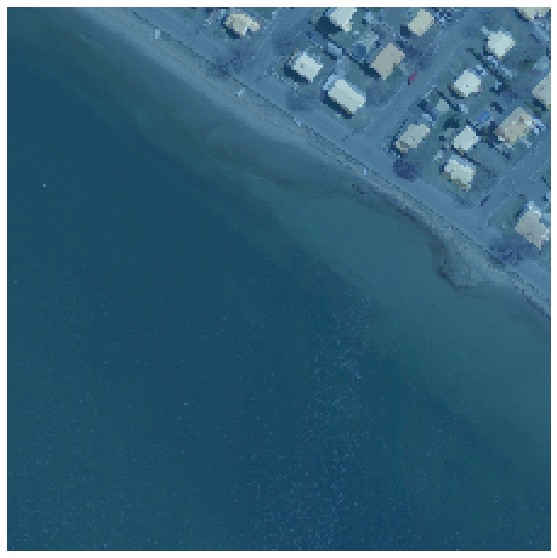

In [9]:
img_f = fnames[-1]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [10]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[224 224]


tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 1, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [11]:
size = 224
bs = 6

In [12]:
codes = np.array(['Empty','Building'])

In [13]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [14]:
src = (SegItemListCustom.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes))

/home/splash/anaconda3/envs/fastai1/lib/python3.7/site-packages/fastai/data_block.py:212: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [15]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data

In [ ]:
data.valid_ds.items

In [ ]:
data.train_ds.x[1]

In [ ]:
data.train_ds.y[1]

In [ ]:
data.train_ds.y[1].data

In [ ]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

In [ ]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

In [ ]:
data.classes

# Custom Loss

In [16]:
import pdb

In [17]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [18]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [19]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, accuracy_thresh, dice]

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [21]:
learn.metrics = metrics

In [22]:
learn.metrics

[<function __main__.dice_loss(input, target)>,
 <function fastai.metrics.accuracy_thresh(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x7f86b8bd3f28>>,
 <function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, eps: float = 1e-08) -> <function NewType.<locals>.new_type at 0x7f86b8bd3f28>>]

In [23]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [24]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [25]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [ ]:
learn.fit_one_cycle(40, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-512-best')
                    ]
                   )

In [26]:
learn.load('20190108-rn34unet-comboloss-alldata-512-best')
learn.model.train()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [27]:
learn.unfreeze()
#learn.lr_find()

In [ ]:
learn.recorder.plot()

In [28]:
lr = 1e-3

In [29]:
learn.fit_one_cycle(80, max_lr=slice(1e-6,lr/10), 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-224-unfreeze-best')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.302377,0.309232,0.183670,0.952809,0.806488,07:18
1,0.310037,0.335796,0.197579,0.952288,0.787527,07:08
2,0.305214,0.313696,0.185505,0.951836,0.813076,07:07
3,0.333057,0.317515,0.189641,0.949546,0.808179,07:07
4,0.314373,0.335896,0.201629,0.947487,0.789743,07:07
5,0.331530,0.328567,0.194698,0.946256,0.808703,07:07
6,0.327753,0.339812,0.200658,0.944360,0.802163,07:08
7,0.311013,0.333848,0.195364,0.946956,0.803232,07:08
8,0.314022,0.309704,0.185548,0.953504,0.811075,07:08
9,0.335364,0.322954,0.192701,0.951052,0.797683,07:08


Better model found at epoch 0 with dice value: 0.8064878582954407.
Better model found at epoch 2 with dice value: 0.813075840473175.
Better model found at epoch 14 with dice value: 0.8155096173286438.
Better model found at epoch 15 with dice value: 0.8159399032592773.
Better model found at epoch 17 with dice value: 0.8233569860458374.
Better model found at epoch 20 with dice value: 0.8334403038024902.
Better model found at epoch 22 with dice value: 0.8334871530532837.
Better model found at epoch 23 with dice value: 0.8364405035972595.
Better model found at epoch 27 with dice value: 0.8404756188392639.
Better model found at epoch 28 with dice value: 0.8461974263191223.
Better model found at epoch 31 with dice value: 0.8512347936630249.
Better model found at epoch 33 with dice value: 0.858765721321106.
Better model found at epoch 35 with dice value: 0.8623340725898743.
Better model found at epoch 40 with dice value: 0.8629769682884216.
Better model found at epoch 41 with dice value: 0.86

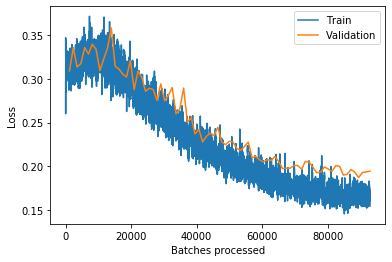

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [32]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [33]:
outputs.shape

torch.Size([6, 2, 224, 224])

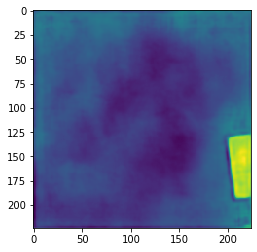

In [34]:
plt.imshow((outputs[2][1]).numpy())

In [35]:
outputs[2].shape

torch.Size([2, 224, 224])

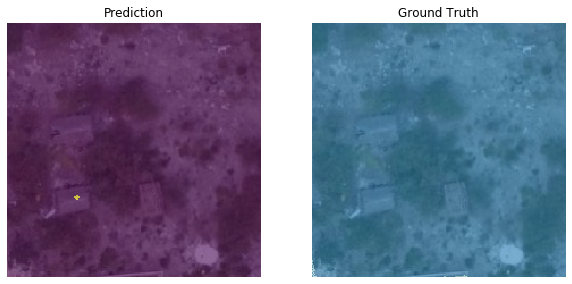

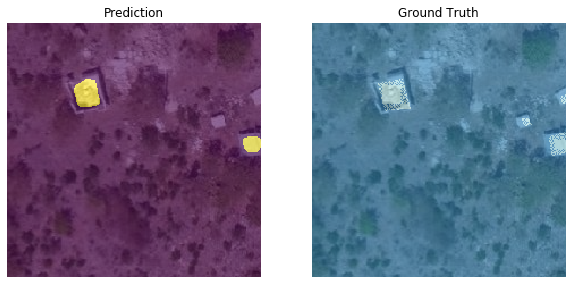

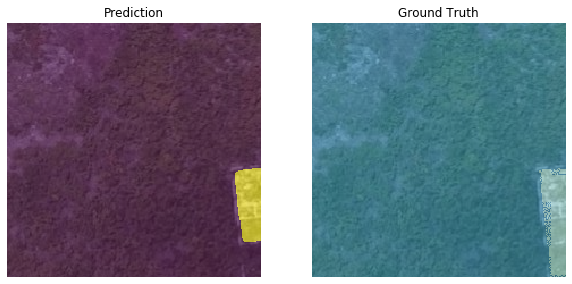

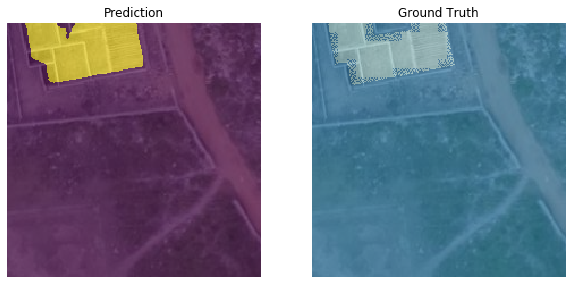

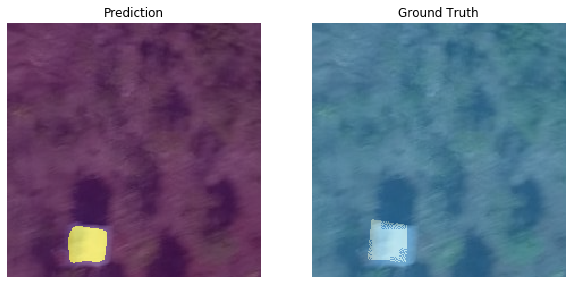

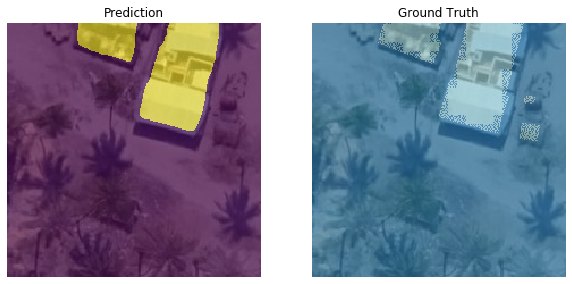

In [36]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.95)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

# Exporting Model for Web

In [ ]:
#ImageDataBunch.export(fn = './export.pkl')
#learn.export()